# Number of level-crossings

In the 2014 Thomson and Haley paper, space physics data are given that appear to have _large numbers of peaks_ that may signify the modulating effects of rather minor variations in the solar magnetic field on the solar wind. Given that this hypothesis may have far-reaching consequences, we quantify how many significant peaks a multitaper spectrum estimate computed on white noise ought to have. 

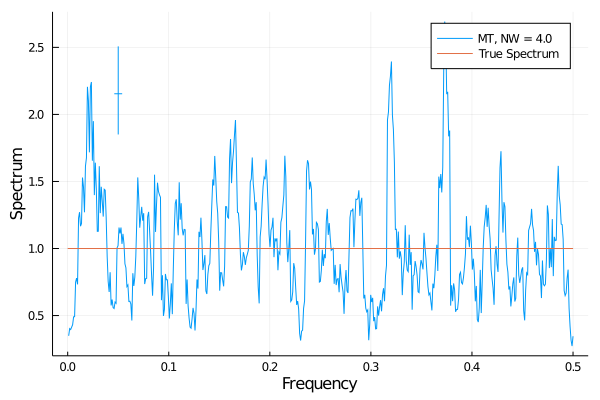

In [14]:
using Multitaper, Random, Plots

N = 1024
Random.seed!(123)
whitenoise = randn(N)
NW = 4.0; K = 7
S = multispec(whitenoise, NW = NW, K = K, a_weight = false, guts=true);

plot(S,yscale = :identity, label="MT, NW = 4.0")
plot!(S.f[[1,end]], ones(2,1), label = "True Spectrum")

A white noise process has a flat spectrum, and note that we have plotted the spectrum on a linear scale. The multitaper spectrum consists of $K$ spectrum estimates, each of which are $\chi^2_2$ distributed, which means their sum is $\chi^2_{2K}$ distributed and their average is $\Gamma(K, 1/K)$ distributed, so we can label the above spectrum with signficance levels. 

Note that _all significant peaks are spurious._

In [2]:
using Distributions
sig = [0.05, 0.5, 0.9, 0.99, 0.999, 0.9999]
z = quantile.(Gamma(K, 1/K), sig)

6-element Array{Float64,1}:
 0.46933081312781033
 0.9528052963642532
 1.5045817294997899
 2.0815169814766286
 2.580233834314152
 3.041377782365235

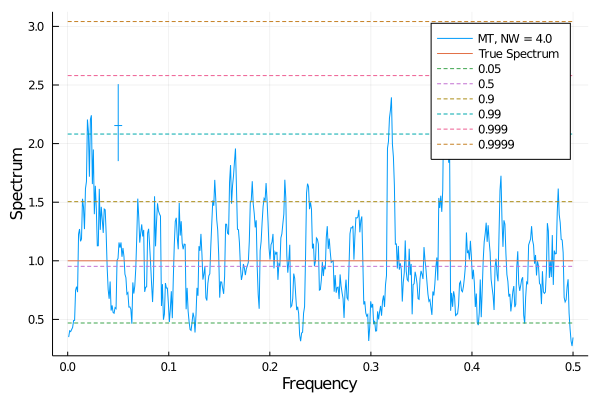

In [3]:
plot!(S.f[[1,end]], kron(ones(2,1),transpose(z)), label = sig', 
    line = :dash, legend = :topright)

So let's count the number of upcrossings that we get.

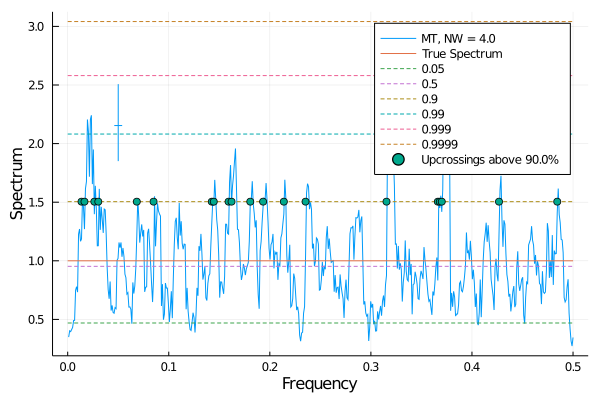

In [4]:
function upcrossing_times(x::Vector{Float64}, thresh::Float64)
  return findall(y -> y < 0, diff(x .- thresh .< 0.0))
end

freks = S.f[upcrossing_times(S.S,z[3])]
scatter!(freks,z[3]*ones(length(freks)), label = "Upcrossings above $(100*sig[3])%")


Note the difference between the upcrossing counter, below.

In [5]:
function upcrossing_N(x::Vector{Float64}, thresh::Float64)
  return sum(y -> y < 0, diff(x .- thresh .< 0.0))
end

upcrossing_N(S.S, z[3])

20

And the crossing counter, below. We will use the crossing counter, generically. Note that the result of the crossing counter is often just double that of the upcrossing counter.

In [6]:
function ccount(x,thresh)
    return sum(abs.(diff(x .> thresh)))
end

ccount(S.S, z[3])

40

Let's count all of the levels.

In [7]:
crsngs = map(x->ccount(S.S,x), z)
hcat(sig*100,z,crsngs)

6×3 Array{Float64,2}:
  5.0   0.469331  20.0
 50.0   0.952805  80.0
 90.0   1.50458   40.0
 99.0   2.08152    8.0
 99.9   2.58023    2.0
 99.99  3.04138    0.0

Great! 

Now, theoretically, a $\Gamma(K, 1/K)$ process is actually a process for which we know the level crossing rate. 
Barakat and others showed that the level crossing rate at each threshold is given by equation (4.2) in the Thomson and Haley paper. Note that this depends on the serial correlations and their second derivative evaluated at zero, eqn (4.3). 

One important thing about that formula is the idea of Rayleigh resolution. This is the smallest separation in frequency that could be resolvable from a sample of size N with sampling rate $\Delta t$. Be careful! The Rayleigh resolution is *always* $1/(N\Delta t)$ and _does not change_ with zero-padding.   

Continuing, we can evaluate (4.2) for the multitaper eventually arriving at (4.22) and (4.23), and in fact, the supplement to TH14 includes values of (4.22) and (4.23) pre-calculated. Note that when N is large, the calculations don't change much into the last decimal places, so we have used N = 1024 and extrapolated for the calculation of $\psi$. This is easy to verify for yourself. 

Now suppose we have a multitaper spectrum computed with $NW = CR = 4.0$, and $K = \alpha = 6$ tapers, the number of upcrossings we expect in 512 Rayleigh resolutions (From 0 to 0.5) is:

In [8]:
tab, lab = uctable(K, NW, num_Ray = 512, sig=sig) 
println(join(lab,", "))
println(join(tab[3,:],", "))
println(join(tab[4,:],", "))

P%, z, U(z,α), D(z,α)
90.0, 1.5045817294997899, 29.806532131501577, 1.7177442774662248
99.0, 2.0815169814766286, 4.331716352596718, 1.181979516486747


This particular function outputs a little table for you which contains the number of upcrossings for that particular multitaper estimate at that significance, prints the level z, and the dwell band, namely the number of Rayleigh resolutions over which we expect the process to stay above the level, on average. Let's add the results from our white noise process simulation to the table. Since the number of upcrossings is supposed to be a Poisson counting process, we can use square root of the number of upcrossings as the standard deviation. 

In [9]:
println(join(lab[1:3],", ")*", sigma, Gauss")
hcat(tab[:,1:3],sqrt.(tab[:,3]),crsngs)

P%, z, U(z,α), sigma, Gauss


6×5 Array{Float64,2}:
  5.0   0.469331  21.5253     4.63954   20.0
 50.0   0.952805  72.7897     8.53169   80.0
 90.0   1.50458   29.8065     5.45954   40.0
 99.0   2.08152    4.33172    2.08128    8.0
 99.9   2.58023    0.533144   0.730167   2.0
 99.99  3.04138    0.0615335  0.24806    0.0

One can compare this with Table 1 on page 7 of Thomson and Haley if we swap out 512 with 10000 for the number of Rayleighs. 

In [10]:
tab, lab = uctable(K, NW, num_Ray = 100000, sig=sig)
tab

6×4 Array{Float64,2}:
  5.0   0.469331   4204.16    22.5967
 50.0   0.952805  14216.7      3.51698
 90.0   1.50458    5821.59     1.71774
 99.0   2.08152     846.038    1.18198
 99.9   2.58023     104.13     0.960341
 99.99  3.04138      12.0183   0.832066

We get half as many upcrossings as are expected. Just for kicks, let's illustrate what happens when we average two multitaper spectrum estimates that have no overlap.

Now suppose we had wanted to use a periodogram instead. How many upcrossings would we get?

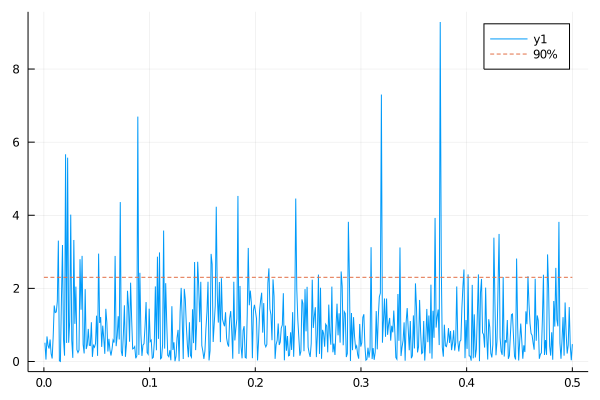

In [11]:
using FFTW

Pxx = abs2.(fft(whitenoise))/length(whitenoise)
freq = LinRange(0,1,length(whitenoise)+1)
halffreq = Int64(length(whitenoise)/2) + 1
plot(freq[2:halffreq],Pxx[2:halffreq])
z = quantile.(Chisq(2), [0.9])/2
plot!(freq[[1,halffreq]], kron(ones(2,1),transpose(z)), label = "90%", 
    line = :dash, legend = :topright)

In [12]:
E_pgram_crsngs = (N/2)*Pgram_upcrossings.(z, N) 

1-element Array{Float64,1}:
 79.50453598301033

Compare with the number of spurious peaks given by the multitaper (20, above), and it is clear that you get a lot more false detections of line components if you use a periodogram. 

Finally, suppose you used a periodogram to estimate the spectrum. How many more spurious upcrossings would you get by not using a multitaper estimate? The answer to this is shown in Figure 2a) Here we replicate this figure so you can play with NW and K.

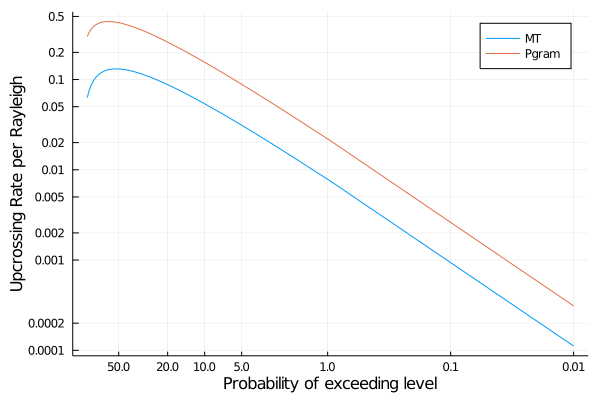

In [13]:
sig = LinRange(0.0001, 0.9, 100)
l = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0002, 0.0001]
m = [0.5, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001]

K = 8; NW = 5.0
Z = quantile.(Chisq(2*K), 1.0 .- sig)/(2*K)
U = MT_Upcrossings.(Z, K, NW, 1024)
plot(sig, U, xscale=:log10, xaxis = :flip, yscale=:log10, label="MT", xlabel = "Probability of exceeding level",
    ylabel = "Upcrossing Rate per Rayleigh", 
    yticks = (l,l), xticks=(m,m*100))

Z_pgram = quantile.(Chisq(2),1.0 .- sig)/2
NCP = Pgram_upcrossings.(Z_pgram, N) 
plot!(sig, NCP, xaxis = :flip, xscale =:log10, yscale=:log10, label= "Pgram")